In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
from tqdm import tqdm
from rl_glue import RLGlue
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import random

from collections import deque

from tbu_gym.tbu_discrete import TruckBackerEnv_D



In [2]:
def set_global_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:
class QRCAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        lr=1e-3,
        gamma=0.99,
        epsilon=0.5,
        epsilon_decay=0.995,
        epsilon_min=0.01,
        buffer_size=50000,
        batch_size=64,
        beta=1,     # weight decay for h-net (small default)
        device=None,
        seed=None
    ):
        if seed is not None:
            self.seed = seed
            torch.manual_seed(seed)
            np.random.seed(seed)
            random.seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(seed)
                torch.cuda.manual_seed_all(seed)
            # Make CUDA operations deterministic (optional, may slow down training)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        else:
            self.seed = None
        # Basic configs
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.beta = beta

        # Replay buffer
        self.memory = deque(maxlen=buffer_size)

        # Device
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Networks (simple MLPs)
        self.q_nn = self.build_nn(output_dim=action_dim).to(self.device)
        self.target_net = self.build_nn(output_dim=action_dim).to(self.device)
        self.h_net = self.build_nn(output_dim=action_dim).to(self.device)

        # Initialize target net
        self.target_net.load_state_dict(self.q_nn.state_dict())
        self.target_net.eval()

        # Optimizers
        self.q_optimizer = optim.Adam(self.q_nn.parameters(), lr=self.lr)
        self.h_optimizer = optim.AdamW(self.h_net.parameters(), lr=self.lr, weight_decay=self.beta)

        self.steps = 0

    def build_nn(self, output_dim):
        """Simple 2-layer MLP"""
        return nn.Sequential(
            nn.Linear(self.state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def agent_policy(self, state):
        """Epsilon-greedy"""
        if np.random.rand() < self.epsilon:
            return int(np.random.randint(self.action_dim))

        state_t = torch.FloatTensor(state).unsqueeze(0).to(self.device)  # (1, state_dim)
        with torch.no_grad():
            q_values = self.q_nn(state_t)  # (1, action_dim)
        return int(q_values.argmax(dim=1).item())

    def remember(self, s, a, r, s2, done):
        self.memory.append((s, a, r, s2, done))

    def compute_loss(self, batch):
        states, actions, rewards, next_states, dones = batch

        states = torch.tensor(np.stack(states), dtype=torch.float32).to(self.device)            
        next_states = torch.tensor(np.stack(next_states), dtype=torch.float32).to(self.device)  
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(self.device)          
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)       
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)           

        # Current Q(s,a)
        q_values = self.q_nn(states)                  
        q_sa = q_values.gather(1, actions)            

        # Next Q from target net — do NOT use no_grad() here,
        # because correction term needs gradients w.r.t. target_net.
        next_q_vals = self.target_net(next_states)    
        next_q = next_q_vals.max(1)[0].unsqueeze(1)   


        # Standard TD target
        delta = (rewards + self.gamma * (1.0 - dones) * next_q.detach()) - q_sa

        delta_detached_for_h = delta.detach()

        # Predict correction h(s,a)
        h_values = self.h_net(states)                      
        h_sa = h_values.gather(1, actions)                 

        # td_loss (0.5 * MSE)
        td_loss = 0.5 * (delta.pow(2)).mean()

        # delta_hat (we detach h_sa for correction so the correction backward affects only target_net)
        delta_hat_detached = h_sa.detach()

        # correction term: gamma * <h, x> * Q(s', a')  -> next_q is from target_net (has grad)
        correction_term = (self.gamma * delta_hat_detached * next_q).mean()

        # h loss: regress h(s,a) to delta.detach()  (this uses delta_detached_for_h so no q-network graph)
        h_loss = 0.5 * ((delta_detached_for_h - h_sa).pow(2)).mean()

        return td_loss, correction_term, h_loss

    def train_with_mem(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # compute losses (td_loss, correction_term, h_loss)
        td_loss, correction_term, h_loss = self.compute_loss(
            (states, actions, rewards, next_states, dones)
        )

        # zero grads on policy and target nets
        self.q_optimizer.zero_grad()
        for p in self.target_net.parameters():
            if p.grad is not None:
                p.grad.zero_()

        # 1) compute gradients for td_loss w.r.t policy network parameters
        td_loss.backward(retain_graph=False)   # no need to retain graph, since h_loss does not use q-graph now

        # 2) compute gradients for correction_term w.r.t target_net parameters
        correction_term.backward(retain_graph=False)

        # 3) add target_net grads to policy network grads (mirror reference code)
        for (policy_param, target_param) in zip(self.q_nn.parameters(), self.target_net.parameters()):
            if target_param.grad is not None:
                if policy_param.grad is None:
                    policy_param.grad = target_param.grad.clone()
                else:
                    policy_param.grad.add_(target_param.grad)

        # 4) step policy optimizer (updates q_nn)
        self.q_optimizer.step()

        # ---- Update h_net (separately) ----
        # Because h_loss used delta.detach(), its computational graph only depends on h_net parameters.
        self.h_optimizer.zero_grad()
        h_loss.backward()
        self.h_optimizer.step()

        # Epsilon decay
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        overall_loss = td_loss.item() + correction_term.item() + h_loss.item()
        return overall_loss

    # Target network update (hard update)
    def update_target(self):
        self.target_net.load_state_dict(self.q_nn.state_dict())

In [ ]:
# Simplified QRC

In [4]:
# --- 1. Hyperparameters ---

num_episodes = 1000
max_steps_per_episode = 500
gamma = 0.99
learning_rate = 1e-3
epsilon_start = 0.5
epsilon_decay = 0.99997
epsilon_min = 0.01
batch_size = 64
target_update_freq = 5  # Update target net every few episodes

# QRC Specific Parameters
alpha = 1.0
sigma_min = 0.0
sigma_max = 1.0

In [ ]:
seeds = list(range(20))  #list of seed 0- n-1
all_rewards = []       

for seed in seeds:
    print(f"\n=== Running Seed {seed} ===")
    set_global_seed(seed)

    # ---- env + agent
    env = TruckBackerEnv_D(render_mode=None)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = QRCAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        lr=learning_rate,
        gamma=gamma,
        epsilon=epsilon_start,
        epsilon_decay=epsilon_decay,
        min_epsilon=epsilon_min,
        batch_size=batch_size
    )

    episode_rewards = []

    for episode in range(1, num_episodes + 1):
        reset_output = env.reset()
        if isinstance(reset_output, tuple):
            state, _ = reset_output
        else:
            state = reset_output

        total_reward = 0

        for t in range(max_steps_per_episode):

            action = agent.agent_policy(state)
            step_result = env.step(action)

            if len(step_result) == 5:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = step_result

            total_reward += reward

            agent.remember(state, action, reward, next_state, done)
            agent.train_with_mem()

            state = next_state
            if done:
                break

        if episode % target_update_freq == 0:
            agent.update_target()

        episode_rewards.append(total_reward)

    all_rewards.append(episode_rewards)



=== Running Seed 0 ===

=== Running Seed 1 ===

=== Running Seed 2 ===

=== Running Seed 3 ===

=== Running Seed 4 ===

=== Running Seed 5 ===

=== Running Seed 6 ===

=== Running Seed 7 ===

=== Running Seed 8 ===

=== Running Seed 9 ===

=== Running Seed 10 ===

=== Running Seed 11 ===

=== Running Seed 12 ===

=== Running Seed 13 ===

=== Running Seed 14 ===

=== Running Seed 15 ===

=== Running Seed 16 ===

=== Running Seed 17 ===

=== Running Seed 18 ===

=== Running Seed 19 ===


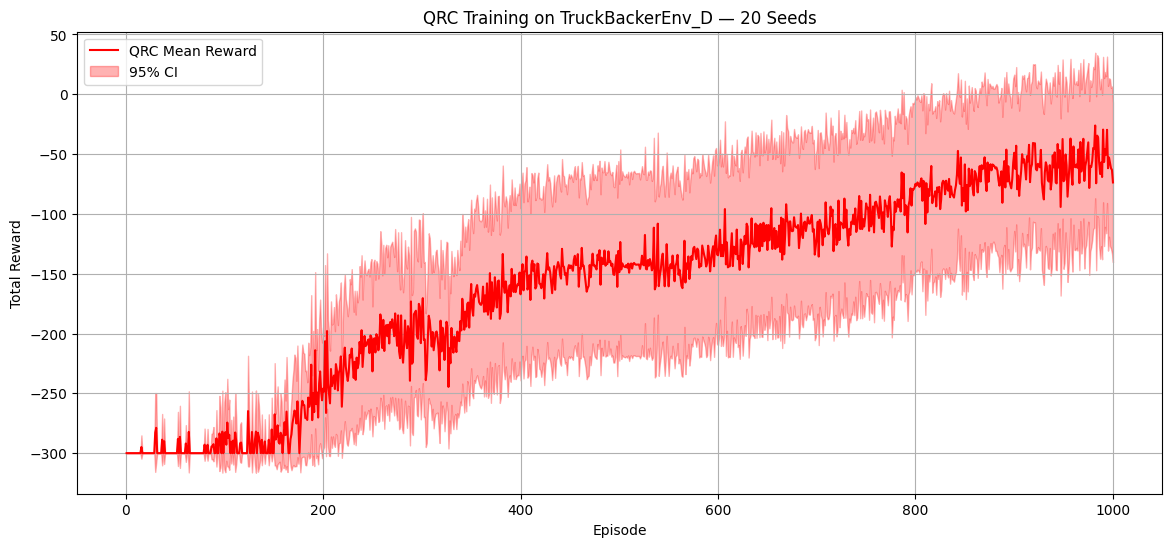

In [6]:
#to ploit 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

all_rewards = np.array(all_rewards)             
mean_rewards = np.mean(all_rewards, axis=0)
std_rewards  = np.std(all_rewards, axis=0)
ci_95 = 1.96 * (std_rewards / np.sqrt(len(seeds)))

episodes = np.arange(1, num_episodes + 1)

plt.figure(figsize=(14, 6))

sns.lineplot(
    x=episodes,
    y=mean_rewards,
    label="QRC Mean Reward",
    color="red"
)

plt.fill_between(
    episodes,
    mean_rewards - ci_95,
    mean_rewards + ci_95,
    alpha=0.3,
    color="red",
    label="95% CI"
)

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('QRC Training on TruckBackerEnv_D — 20 Seeds')
plt.grid(True)
plt.legend()
plt.show()
